<a href="https://colab.research.google.com/github/Jonny-T87/ML-Projects/blob/main/YahooTrendlineTradingStrategyBacktest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [453]:
import yfinance as yf
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

In [454]:
# Download historical data for QQQ and SPY
qqq = yf.download('QQQ', start='2024-07-02', end='2024-08-05', interval='5m')
spy = yf.download('SPY', start='2024-07-02', end='2024-08-05', interval='5m')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [455]:
qqq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1758 entries, 2024-07-02 09:30:00-04:00 to 2024-08-02 15:55:00-04:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1758 non-null   float64
 1   High       1758 non-null   float64
 2   Low        1758 non-null   float64
 3   Close      1758 non-null   float64
 4   Adj Close  1758 non-null   float64
 5   Volume     1758 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 96.1 KB


In [456]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1756 entries, 2024-07-02 09:30:00-04:00 to 2024-08-02 15:55:00-04:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1756 non-null   float64
 1   High       1756 non-null   float64
 2   Low        1756 non-null   float64
 3   Close      1756 non-null   float64
 4   Adj Close  1756 non-null   float64
 5   Volume     1756 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 96.0 KB


In [457]:
qqq.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-07-02 09:30:00-04:00,480.380005,481.750000,480.279999,481.390015,481.390015,1257365
2024-07-02 09:35:00-04:00,481.390015,482.190002,480.945007,481.779999,481.779999,648942
2024-07-02 09:40:00-04:00,481.801605,482.829987,481.549988,482.528992,482.528992,523014
2024-07-02 09:45:00-04:00,482.519989,483.179993,482.279999,482.290009,482.290009,517111
2024-07-02 09:50:00-04:00,482.320007,482.650085,481.880005,482.549896,482.549896,522553


In [458]:
spy.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-07-02 09:30:00-04:00,543.700012,544.690002,543.650024,544.630005,544.630005,1646246
2024-07-02 09:35:00-04:00,544.640015,545.229980,544.340027,545.049194,545.049194,658601
2024-07-02 09:40:00-04:00,545.070007,545.679993,544.940002,545.159973,545.159973,574513
2024-07-02 09:45:00-04:00,545.140015,545.590027,545.049988,545.130005,545.130005,433493
2024-07-02 09:50:00-04:00,545.130005,545.340027,544.739990,545.135010,545.135010,371290


In [459]:
# Resample to 15-minute intervals (if necessary)
def resample_data(data):
    data = data.resample('5T').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    return data

In [460]:
qqq_data = resample_data(qqq)
spy_data = resample_data(spy)

In [461]:
qqq_data.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-07-02 09:30:00-04:00,480.380005,481.750000,480.279999,481.390015,1257365
2024-07-02 09:35:00-04:00,481.390015,482.190002,480.945007,481.779999,648942
2024-07-02 09:40:00-04:00,481.801605,482.829987,481.549988,482.528992,523014
2024-07-02 09:45:00-04:00,482.519989,483.179993,482.279999,482.290009,517111
2024-07-02 09:50:00-04:00,482.320007,482.650085,481.880005,482.549896,522553


In [462]:
# Calculate indicators
def calculate_indicators(data):
    data['EMA10'] = data['Close'].ewm(span=10, adjust=False).mean()

    #MACD Calculations
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()


    low_min = data['Low'].rolling(window=2).min()
    high_max = data['High'].rolling(window=2).max()
    #data['Stochastic_%K'] = 100 * (data['Close'] - low_min) / (high_max - low_min)
    #data['Stochastic_%D'] = data['Stochastic_%K'].rolling(window=3).mean()
    data['TR'] = np.maximum(data['High'] - data['Low'],
                            np.maximum(abs(data['High'] - data['Close'].shift(1)),
                                       abs(data['Low'] - data['Close'].shift(1))))
    data['ATR'] = data['TR'].rolling(window=2).mean()
    return data

In [463]:
qqq_data = calculate_indicators(qqq_data)
spy_data = calculate_indicators(spy_data)

In [464]:
# Identify trend lines
def identify_trend_lines(df, order=2):
    df['min'] = df.iloc[argrelextrema(df['Low'].values, np.less_equal, order=order)[0]]['Low']
    df['max'] = df.iloc[argrelextrema(df['High'].values, np.greater_equal, order=order)[0]]['High']
    return df

In [465]:
qqq_data = identify_trend_lines(qqq_data)
spy_data = identify_trend_lines(spy_data)

In [466]:
# Define the strategy
def strategy(df):
    df['Signal'] = 0
    # Long Entry
    df['Signal'] = np.where(
        (df['Close'] > df['EMA10']) &
        (df['MACD'] > df['MACD_signal']) &
        #(df['Stochastic_%K'] < 20) &
        #(df['Stochastic_%K'] > df['Stochastic_%D']) &
        (df['Low'] >= df['min']), 1, df['Signal']
    )
    # Short Entry
    df['Signal'] = np.where(
        (df['Close'] < df['EMA10']) &
        (df['MACD'] < df['MACD_signal']) &
        #(df['Stochastic_%K'] > 80) &
        #(df['Stochastic_%K'] < df['Stochastic_%D']) &
        (df['High'] <= df['max']), -1, df['Signal']
    )
    return df

In [467]:
qqq_data = strategy(qqq_data)
spy_data = strategy(spy_data)

In [468]:
# Define a function to classify trending and ranging days
def classify_days(data):
    data['Day'] = data.index.date
    data['Range'] = data['High'] - data['Low']
    data['Trend'] = data['Close'] - data['Open']
    data['RangeThreshold'] = data['Range'].mean()
    data['TrendThreshold'] = data['Trend'].mean()

    data['DayType'] = np.where((data['Range'] >= data['RangeThreshold']) & (abs(data['Trend']) >= data['TrendThreshold']), 'Trending', 'Ranging')
    return data

In [469]:
qqq_data = classify_days(qqq_data)
spy_data = classify_days(spy_data)

In [470]:
qqq_data.head()

,Open,High,Low,Close,Volume,EMA10,MACD,MACD_signal,TR,ATR,min,max,Signal,Day,Range,Trend,RangeThreshold,TrendThreshold,DayType
Datetime,,,,,,,,,,,,,,,,,,,
2024-07-02 09:30:00-04:00,480.380005,481.750000,480.279999,481.390015,1257365,481.390015,0.000000,0.000000,NaN,NaN,480.279999,NaN,0,2024-07-02,1.470001,1.010010,0.766012,-0.025559,Trending
2024-07-02 09:35:00-04:00,481.390015,482.190002,480.945007,481.779999,648942,481.460921,0.031110,0.006222,1.244995,NaN,NaN,NaN,0,2024-07-02,1.244995,0.389984,0.766012,-0.025559,Trending
2024-07-02 09:40:00-04:00,481.801605,482.829987,481.549988,482.528992,523014,481.655116,0.114878,0.027953,1.279999,1.262497,NaN,NaN,0,2024-07-02,1.279999,0.727386,0.766012,-0.025559,Trending
2024-07-02 09:45:00-04:00,482.519989,483.179993,482.279999,482.290009,517111,481.770551,0.160135,0.054389,0.899994,1.089996,NaN,483.179993,0,2024-07-02,0.899994,-0.229980,0.766012,-0.025559,Trending
2024-07-02 09:50:00-04:00,482.320007,482.650085,481.880005,482.549896,522553,481.912250,0.214499,0.086411,0.770081,0.835037,NaN,NaN,0,2024-07-02,0.770081,0.229889,0.766012,-0.025559,Trending


In [471]:
qqq_data['Signal'].value_counts()

Signal
 0    1652
-1      58
 1      48
Name: count, dtype: int64

In [472]:
# Count number of possible trades on trending and ranging periods
def count_trades_per_day(data):
    # Calculate the trade count for each day
    daily_trade_count = data['Signal'].abs().groupby(data.index.date).count()
    # Create a DataFrame with 'Day' and 'TradeCount' columns
    daily_trade_count = daily_trade_count.reset_index(name='TradeCount').rename(columns = {'index':'Day'}) # Convert the Series to a DataFrame and rename the columns
    # Merge the trade count with the original data to get the 'DayType' column
    daily_trade_count = daily_trade_count.merge(data[['Day', 'DayType']], on='Day', how='left')
    # Group by 'Day' and 'DayType' and sum the trade counts
    daily_trade_count = daily_trade_count.groupby(['Day','DayType'])['TradeCount'].count().reset_index()
    return daily_trade_count

In [473]:
daily_trade_count_qqq = count_trades_per_day(qqq_data)
daily_trade_count_spy = count_trades_per_day(spy_data)
DayType = daily_trade_count_qqq['DayType']

print("Daily Possible Period Trade Count for QQQ: " ,daily_trade_count_qqq)
print("Daily Possible Period Trade Count for SPY: ",daily_trade_count_spy)

Daily Possible Period Trade Count for QQQ:             Day   DayType  TradeCount
0   2024-07-02   Ranging          63
1   2024-07-02  Trending          15
2   2024-07-03   Ranging          37
3   2024-07-03  Trending           5
4   2024-07-05   Ranging          70
5   2024-07-05  Trending           8
6   2024-07-08   Ranging          74
7   2024-07-08  Trending           4
8   2024-07-09   Ranging          71
9   2024-07-09  Trending           7
10  2024-07-10   Ranging          77
11  2024-07-10  Trending           1
12  2024-07-11   Ranging          42
13  2024-07-11  Trending          36
14  2024-07-12   Ranging          58
15  2024-07-12  Trending          20
16  2024-07-15   Ranging          50
17  2024-07-15  Trending          28
18  2024-07-16   Ranging          49
19  2024-07-16  Trending          29
20  2024-07-17   Ranging          52
21  2024-07-17  Trending          26
22  2024-07-18   Ranging          21
23  2024-07-18  Trending          57
24  2024-07-19   Ranging       

In [474]:
# Separate trending and ranging days
qqq_data['Movement'] = np.where(qqq_data['DayType'] == 'Trending', 1, 0)
spy_data['Movement'] = np.where(spy_data['DayType'] == 'Trending', 1, 0)

In [475]:
#qqq Trending days
qqq_trending_days = (qqq_data['DayType'] == 'Trending').sum()
#qqq Ranging days
qqq_ranging_days = len(qqq_data) - qqq_trending_days
#spy Trending days
spy_trending_days = (spy_data['DayType'] == 'Trending').sum()
#spy Ranging days
spy_ranging_days = len(spy_data) - spy_trending_days

print('qqq Trending days:', qqq_trending_days)
print('qqq Ranging days:', qqq_ranging_days)
print('spy Trending days:', spy_trending_days)
print('spy Ranging days:', qqq_ranging_days)


qqq Trending days: 703
qqq Ranging days: 1055
spy Trending days: 692
spy Ranging days: 1055


In [476]:
# Print average trades per day for trending and ranging days
print(f"Average trades per day on trending days: {daily_trade_count_qqq[daily_trade_count_qqq['DayType'] == 'Trending']['TradeCount'].mean()}")
print(f"Average trades per day on ranging days: {daily_trade_count_qqq[daily_trade_count_qqq['DayType'] == 'Ranging']['TradeCount'].mean()}")

Average trades per day on trending days: 30.565217391304348
Average trades per day on ranging days: 45.869565217391305


In [477]:
# Backtest the strategy with risk and reward
def backtest(data, initial_balance=100000):
    balance = initial_balance
    positions = []

    for index, row in data.iterrows():
        if row['Signal'] == 1:
            # Long entry
            stop_loss = row['Close'] - row['ATR']
            take_profit = row['Close'] + 1.5 * row['ATR']
            positions.append((index, 'long', row['Close'], stop_loss, take_profit))
        elif row['Signal'] == -1:
            # Short entry
            stop_loss = row['Close'] + row['ATR']
            take_profit = row['Close'] - 1.5 * row['ATR']
            positions.append((index, 'short', row['Close'], stop_loss, take_profit))

    trades = []
    for index, position in enumerate(positions):
        entry_time, direction, entry_price, stop_loss, take_profit = position
        trade_result = None
        for idx in range(index + 1, len(data)):
            if direction == 'long':
                if data.iloc[idx]['Low'] <= stop_loss:
                    trade_result = (entry_time, data.index[idx], 'stop_loss', entry_price, stop_loss)
                    balance -= (entry_price - stop_loss) * 100
                    break
                elif data.iloc[idx]['High'] >= take_profit:
                    trade_result = (entry_time, data.index[idx], 'take_profit', entry_price, take_profit)
                    balance += (take_profit - entry_price) * 100
                    break
            elif direction == 'short':
                if data.iloc[idx]['High'] >= stop_loss:
                    trade_result = (entry_time, data.index[idx], 'stop_loss', entry_price, stop_loss)
                    balance -= (stop_loss - entry_price) * 100
                    break
                elif data.iloc[idx]['Low'] <= take_profit:
                    trade_result = (entry_time, data.index[idx], 'take_profit', entry_price, take_profit)
                    balance += (entry_price - take_profit) * 100
                    break

        if trade_result:
            trades.append(trade_result)

    return balance, trades

In [478]:
# Run the backtest
qqq_balance, qqq_trades = backtest(qqq_data)
spy_balance, spy_trades = backtest(spy_data)


In [479]:
# Print the results
def print_results(symbol, initial_balance, final_balance, trades):
    print(f"Results for {symbol}:")
    print(f"Initial Balance: {initial_balance}")
    print(f"Final Balance: {final_balance}")
    print(f"Number of Trades: {len(trades)}")
    print(f"Winning Trades: {len([trade for trade in trades if trade[2] == 'take_profit'])}")
    print(f"Losing Trades: {len([trade for trade in trades if trade[2] == 'stop_loss'])}")
    print(f"Win Rate: {len([trade for trade in trades if trade[2] == 'take_profit']) / len(trades) * 100}%")


In [480]:
print_results('QQQ', 100000, qqq_balance, qqq_trades)
print_results('SPY', 100000, spy_balance, spy_trades)

Results for QQQ:
Initial Balance: 100000
Final Balance: 100396.37145996094
Number of Trades: 106
Winning Trades: 43
Losing Trades: 63
Win Rate: 40.56603773584906%
Results for SPY:
Initial Balance: 100000
Final Balance: 102072.60437011719
Number of Trades: 118
Winning Trades: 57
Losing Trades: 61
Win Rate: 48.30508474576271%


In [481]:
#plot results
qqq_data['TradeCount'] = qqq_data['Signal'].abs().groupby(qqq_data.index.date).sum()
spy_data['TradeCount'] = spy_data['Signal'].abs().groupby(spy_data.index.date).sum()

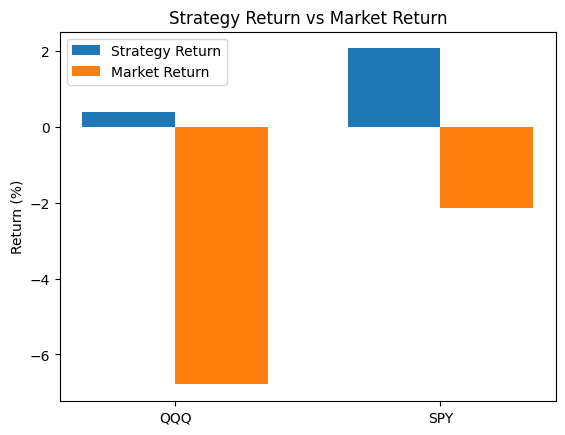

In [482]:


# Assuming backtest() returns a tuple (final_balance, trades)
# and qqq_data and spy_data have a 'Close' column for market prices
qqq_balance, qqq_trades = backtest(qqq_data)
spy_balance, spy_trades = backtest(spy_data)

# Calculate strategy returns
initial_balance = 100000
qqq_strategy_return = (qqq_balance - initial_balance) / initial_balance * 100
spy_strategy_return = (spy_balance - initial_balance) / initial_balance * 100

# Calculate market returns
qqq_market_return = (qqq_data['Close'].iloc[-1] - qqq_data['Close'].iloc[0]) / qqq_data['Close'].iloc[0] * 100
spy_market_return = (spy_data['Close'].iloc[-1] - spy_data['Close'].iloc[0]) / spy_data['Close'].iloc[0] * 100

# Create bar chart
labels = ['QQQ', 'SPY']
strategy_returns = [qqq_strategy_return, spy_strategy_return]
market_returns = [qqq_market_return, spy_market_return]

x = range(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, strategy_returns, width, label='Strategy Return')
rects2 = ax.bar([i + width for i in x], market_returns, width, label='Market Return')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Return (%)')
ax.set_title('Strategy Return vs Market Return')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()